<img src="https://www.escoladnc.com.br/wp-content/uploads/2022/06/dnc_formacao_dados_logo_principal_preto-1.svg" alt="drawing" width="300"/>

# Recomendação baseada em similaridade de conteúdo - Partes 1 e 2

Este notebook contém a implementação de uma recomendação item-item baseada na similaridade de conteúdo. 

**O notebook é dividido em 2 partes**:

1. Representação vetorial com _one-hot-encoding_
2. Representação vetorial com _PCA_

Ambas as partes se utilizam do mesmo pré-processamento.

Para implementar um sistema de recomendação de conteúdo no estilo content-based em Python, você deve se concentrar em alguns conceitos-chave e técnicas. Aqui estão os principais pontos que você deve dominar:

1. Representação de Dados
Vetorização de Texto: A principal técnica para trabalhar com dados textuais (como descrições de produtos, filmes, artigos, etc.) é converter o texto em uma representação numérica. Algumas abordagens importantes incluem:
TF-IDF (Term Frequency-Inverse Document Frequency): Mede a relevância de palavras em um documento com base na frequência e na raridade das palavras.
Bag of Words (BoW): Converte o texto em uma matriz de contagem de palavras, desconsiderando a ordem das palavras.
Word Embeddings: Como o Word2Vec, GloVe, ou FastText para representar palavras em espaços vetoriais contínuos, capturando semelhanças semânticas.
2. Métricas de Similaridade
Cosine Similarity: A similaridade do cosseno é uma das métricas mais populares para medir a semelhança entre dois vetores. Usada para calcular a semelhança entre conteúdos baseados em suas representações vetoriais.
Euclidean Distance: Mede a distância entre dois pontos em um espaço multidimensional, útil para calcular semelhanças entre itens numéricos.
Jaccard Similarity: Para conjuntos de palavras ou atributos discretos, a similaridade de Jaccard pode ser uma boa escolha.
3. Filtragem Baseada em Conteúdo
Construção de Perfis de Usuário: Ao usar a filtragem baseada em conteúdo, é importante construir um perfil de usuário que representa suas preferências, usando as características dos itens com os quais o usuário interage.
Recomendação de Itens: Com base na similaridade entre os itens, recomenda-se conteúdos que sejam mais semelhantes ao que o usuário já interagiu ou demonstrou interesse.
4. Modelagem de Características
Feature Engineering: Para melhorar a recomendação, é importante entender como extrair e selecionar as melhores características (features) dos itens que serão usados no processo de recomendação (ex.: gênero de filmes, categorias de produtos, etc.).
Dimensionalidade Reduzida: Técnicas como PCA (Principal Component Analysis) ou t-SNE para reduzir a dimensionalidade dos dados enquanto mantém as relações de similaridade entre itens.
5. Avaliação de Modelos
Precisão (Precision) e Revocação (Recall): Medem a performance do sistema de recomendação, verificando quão relevantes são as recomendações para o usuário.
F1 Score: A média harmônica entre precisão e revocação, que pode ser útil para avaliar o equilíbrio entre elas.
AUC (Area Under the Curve): Uma métrica que avalia a performance de um modelo de recomendação, especialmente útil para sistemas com grandes volumes de dados desbalanceados.
6. Sistemas de Recomendação Híbridos
Embora o enfoque seja content-based, vale a pena aprender sobre sistemas híbridos, que combinam abordagens baseadas em conteúdo e colaborativas. Isso pode melhorar a precisão e a relevância das recomendações, especialmente em casos de "cold start" (quando não há dados históricos suficientes).

7. Bibliotecas e Ferramentas em Python
Scikit-learn: Para técnicas de aprendizado de máquina, como vetorização de texto (TF-IDF, BoW) e cálculo de similaridade.
Pandas: Para manipulação de dados e construção de conjuntos de treinamento.
NumPy: Para operações matemáticas e manipulação de arrays numéricos.
NLTK ou spaCy: Para processamento de linguagem natural (tokenização, remoção de stopwords, stemming/lemmatization).
Surprise: Para construção de sistemas de recomendação e experimentação com diferentes técnicas (inclusive content-based).
8. Exploração de Dados
Análise Exploratória: Entender os dados, fazer visualizações (com Matplotlib ou Seaborn), e verificar distribuições de características para entender quais podem ser mais úteis para as recomendações.
Conclusão
Focar no processo de representação de dados, métricas de similaridade, e avaliação de desempenho são os pilares essenciais para construir um sistema de recomendação baseado em conteúdo. Além disso, estudar técnicas de engenharia de características e ferramentas específicas de Python como Scikit-learn e NLTK ajudará a implementar esses conceitos de forma eficiente.


In [2]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

# Carregando o dataset

O dataset a ser utilizado (`steam_games.parquet`) contém metadados de 32k jogos da [_Steam_](https://store.steampowered.com/), como:

- `id`: identificador do jogo
- `title`: título do jogo
- `genres`: lista com os gêneros associados ao jogo
- `tags`: lista com tags associadas ao jogo
- `specs`: especificações do jogo
- `release_date`: data de lançamento do jogo
- `price`: preço do jogo
- `sentiment`: avaliação qualitativa do jogo segundo usuários


Upload file `steam_games.parquet`

In [3]:
filepath = r'C:\Users\Shiry\OneDrive\Área de Trabalho\Modulo de recomendação\Anexos_similarity-based-recommendation\steam_games.parquet'
df = pd.read_parquet(filepath)
df.set_index('id', inplace=True)
df.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
id,,,,,,,,,,,,,,,
773640,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,"Nikita ""Ghost_RUS""",None,nan
733530,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,Sacada,None,nan
610660,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,Laush Dmitriy Sergeevich,None,nan
658870,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,"xropi,stev3ns",1 user reviews,nan
681550,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,None,Positive,nan


# Pré-processamento

Para criarmos uma representação vetorial de cada jogo precisamos processar as _features_ de interesse.

In [4]:
df_features = df.copy()

## Release Year
Extraindo o ano de lançamento do campo `release_date`

In [5]:
import re
def extract_year(release_date):
    if type(release_date) == str and re.match('^\d{4}-\d{2}-\d{2}$', release_date):
        return release_date.split('-')[0]

df_features['release_year'] = df_features['release_date'].apply(extract_year)
df_features[['release_date', 'release_year']].head()

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Shiry\AppData\Local\Temp\ipykernel_19364\88211513.py:3: SyntaxWarning: invalid escape sequence '\d'
  if type(release_date) == str and re.match('^\d{4}-\d{2}-\d{2}$', release_date):


,release_date,release_year
id,,
761140,2018-01-04,2018
643980,2018-01-04,2018
670290,2017-07-24,2017
767400,2017-12-07,2017
773570,None,None


## Price
Convertendo o campo `price` para o tipo _float_

In [6]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19442 entries, 761140 to 681550
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       16233 non-null  object 
 1   genres          16314 non-null  object 
 2   app_name        19441 non-null  object 
 3   title           17426 non-null  object 
 4   url             19442 non-null  object 
 5   release_date    17409 non-null  object 
 6   tags            19400 non-null  object 
 7   discount_price  120 non-null    float64
 8   reviews_url     19442 non-null  object 
 9   specs           18773 non-null  object 
 10  price           19442 non-null  object 
 11  early_access    19442 non-null  bool   
 12  developer       16297 non-null  object 
 13  sentiment       17538 non-null  object 
 14  metascore       19442 non-null  object 
 15  release_year    17156 non-null  object 
dtypes: bool(1), float64(1), object(14)
memory usage: 2.4+ MB


In [7]:
def convert_price(price):
    try:
        return float(price)
    except:
        return 0.0
df_features['price_'] = df_features['price'].apply(convert_price)
df_features[['price', 'price_']].head()


,price,price_
id,,
761140,4.99,4.99
643980,Free To Play,0.00
670290,Free to Play,0.00
767400,0.99,0.99
773570,2.99,2.99


## Sentiment
Categorizando o campo `sentiment`

In [8]:
# Nesta função você consegue verifcar todos os valores de uma coluna 
df_features['sentiment'].unique()

array([None, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       'Very Negative', 'Positive', 'Mostly Negative', '9 user reviews',
       'Negative', '4 user reviews', '7 user reviews', '2 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [9]:
#Transformando avaliação de jogos de string para int.
sentiment_map = {
    'Overwhelmingly Positive': 4,
    'Very Positive': 3,
    'Mostly Positive': 2,
    'Positive': 1,
    'Mixed': 0,
    'Negative': -1,
    'Mostly Negative': -2,
    'Very Negative': -3,
    'Overwhelmingly Negative': -4
}
df_features['sentiment_'] = df_features['sentiment'].map(sentiment_map).fillna(0)
df_features[['sentiment', 'sentiment_']].head()

,sentiment,sentiment_
id,,
761140,None,0.0
643980,Mostly Positive,2.0
670290,Mostly Positive,2.0
767400,None,0.0
773570,None,0.0


## Tags e Specs
Aplicando _one-hot-encoding_ (ou representação maximamente esparsa) para os campos de lista `tags` e `specs`.

**Nota**: o campo `genres` não será utilizado pois suas informações já estão contidas no campo `tags`.

In [10]:
df_features['tags'].explode()

id
761140      Strategy
761140        Action
761140         Indie
761140        Casual
761140    Simulation
             ...    
681550     Adventure
681550         Indie
681550        Action
681550    Simulation
681550            VR
Name: tags, Length: 132726, dtype: object

In [11]:
#Criando um data set explodido com get dummies  e anexado ao id , para avaliar o o que recomendar ao usuario.

def clean_list_column(list_column):
    return list_column if type(list_column) == list else []

# df_features['tags_'] = df_features['tags'].apply(clean_list_column)
# df_features['specs_'] = df_features['specs'].apply(clean_list_column)

df_tags = pd.get_dummies(df_features['tags'].explode()).groupby('id').max()
df_specs = pd.get_dummies(df_features['specs'].explode()).groupby('id').max()

df_tags.head()

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,3D Vision,4 Player Local,4X,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
id,,,,,,,,,,,,,,,,,,,,,
10,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100400,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10090,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
100980,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
#Treinando o modelo e mesclando com as  bases esparsa(getdummies)
BASE_FEATURES = ['price_', 'sentiment_', 'release_year']   #base de  avalaiação sentimento , preço e ano
df_train = df_features[BASE_FEATURES].merge(df_tags, left_index=True, right_index=True) #mesclando com o dataset de tags ( estilo de jogos)
df_train = df_train.merge(df_specs, left_index=True, right_index=True) #mesclando com o dataset de especificações
df_train.tail()

#O data_frame df_train ate aqui ainda nao foi treinado , mas esta pronto para o treino.

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,9.99,-2.0,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99700,9.99,3.0,2011,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9980,6.99,0.0,2010,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99900,0.00,3.0,2011,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
99910,0.00,3.0,2011,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


# Parte 1: Representação vetorial simples

A representação vetorial mais simples que podemos fazer é aquela que consideramos todas as _features_ **sem qualquer redução de dimensionalidade**. No entanto, para realizarmos o cálculo da similaridade, é recomendável que os dados estejam normalizados para que uma _feature_ não tenha maior impacto do que a outra no cálculo da similaridade.

Para fazermos a normalização dos dados, utilizaremos as seguintes classes:

- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): escalona as features para o intervalo [0, 1].
- [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html): preenche valores nulos com a média da _feature_.
- [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): agrega todas as transformações em um só objeto.

In [13]:
#chamando libs e treinando o modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

pipeline.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [42]:
#trasnformando em pandas dataframe transformando em novos vertores

def generate_vector_representation(pipeline:Pipeline, preprocessed_data:pd.DataFrame, keep_columns=True):
    df_vectors = pd.DataFrame(pipeline.transform(preprocessed_data))
    if keep_columns:
        df_vectors.columns = preprocessed_data.columns
    df_vectors.index = preprocessed_data.index
    df_vectors.index.name = 'id'
    return df_vectors
df_vectors = generate_vector_representation(pipeline, df_train)
df_vectors.tail()

,price_,sentiment_,release_year,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D Platformer,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
id,,,,,,,,,,,,,,,,,,,,,
9970,0.012945,0.250,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99700,0.012945,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9980,0.009058,0.500,0.816327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99900,0.000000,0.875,0.836735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99910,0.000000,0.875,0.836735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observação:** note a quantidade de _features_ na representação vetorial

## Calculando a matriz de similaridade item-item

Uma vez obtida a representação vetorial de cada item, podemos calcular a matriz de similaridades a partir de uma função de calcula a similaridade entre 2 vetores. Neste notebook utilizaremos a **similaridade cosseno** porém outras funções podem ser consultadas na [documentação de métricas pairwise](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise).

In [15]:
#verificando a similiridade entre os jogos ,pense aqui como se fosse um hitmap


from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_matrix(vectors:pd.DataFrame, similarity_fn=cosine_similarity):
    similarity_matrix = pd.DataFrame(similarity_fn(vectors))
    similarity_matrix.index = vectors.index.astype(str)
    similarity_matrix.index.name = 'id'
    similarity_matrix.columns = vectors.index.astype(str)
    return similarity_matrix

df_item_similarity_matrix = calculate_similarity_matrix(df_vectors)
df_item_similarity_matrix.iloc[:5, :5]

id,10,1002,100400,10090,100980
id,,,,,
10,1.000000,0.253148,0.145029,0.391773,0.154565
1002,0.253148,1.000000,0.226340,0.336925,0.233593
100400,0.145029,0.226340,1.000000,0.147372,0.705245
10090,0.391773,0.336925,0.147372,1.000000,0.154867
100980,0.154565,0.233593,0.705245,0.154867,1.000000


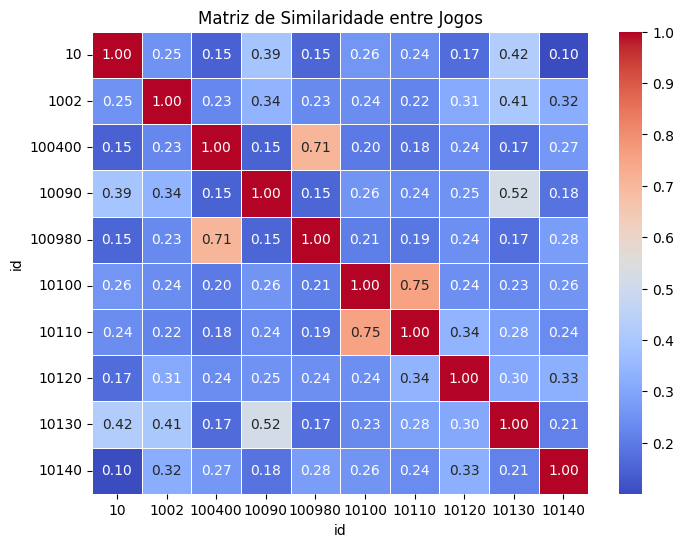

In [32]:
#verificando melhor a similiaridade dos jogos em um grafico heatmap , onde temos um grafico de calor para analisar a similiaridade entre os jogos.

import seaborn as sns
df_item_similarity_matrix_top10 = df_item_similarity_matrix.iloc[:10, :10]

plt.figure(figsize=(8, 6))
sns.heatmap(df_item_similarity_matrix_top10, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Similaridade entre Jogos')
plt.show()

## Gerando recomendações

Uma vez obtida a matriz de similaridade item-item, a recomendação pode ser feita obtendo-se os N items mais similares a um _seed_ (ou item-alvo). Portanto, a função `recommend_similar_items()` recebe como parâmetros:

- `similarity_matrix`: matriz com similaridades pre-computadas.
- `target_id`: ID do item-alvo que será a base das recomendações.
- `N`: a quantidade de itens a serem recomendados.

A saída da função é o conjunto de `id`s dos itens recomendados e o `score` de similaridade.

In [36]:
# verificando os jogos mais similiaridade em todo o data set

id = '12180'  # Grand Theft Auto 2 

def recommend_similar_items(similarity_matrix:pd.DataFrame, target_id:str, n=10):
    target_item_similarities = similarity_matrix.loc[target_id]
    id_similar_items = (
        target_item_similarities
        .sort_values(ascending=False)
        .reset_index()
        .rename({'index': 'id', target_id: 'score'}, axis=1)
    )
    return id_similar_items.head(n).set_index('id')

df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
df_recommended_items

,score
id,
12180,1.000000
12170,0.704370
38430,0.669960
40990,0.647127
2610,0.628885
38490,0.626514
901147,0.621112
6850,0.609481
6880,0.607819


Para facilitar a análise, agregamos os metadados do catálogo e ordenamos por `score`.

**Nota**: o item-alvo intencionalmente aparecerá em 1o lugar pois a similaridade de um item com ele mesmo será sempre máxima. No entanto, em ambientes de produção este item deve ser filtrado da recomendação.

In [18]:
def display_recommendations(recommendations:pd.DataFrame, catalog:pd.DataFrame):
    return (
        recommendations
        .merge(catalog, left_index=True, right_index=True, how='inner')
        .sort_values(by='score', ascending=False)
    )

display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.704370,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.669960,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
40990,0.647127,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
2610,0.628885,GUN™,"[Western, Action, Open World, Third-Person Sho..."
38490,0.626514,Earthworm Jim 2,"[Adventure, Action, Classic, Platformer, 2D]"
901147,0.621112,Earthworm Jim,"[Action, Adventure, Platformer, Classic, 2D]"
6850,0.609481,Hitman 2: Silent Assassin,"[Stealth, Action, Third Person, Singleplayer, ..."
6880,0.607819,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."


Testando diferentes itens de referência

**Nota**: analise a velocidade da recomendação

In [40]:
#id = '12180'  # Grand Theft Auto 2 
#id = '10'     # Counter Striker
id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items = recommend_similar_items(df_item_similarity_matrix, id)
display_recommendations(df_recommended_items, df[['title', 'tags']])

,score,title,tags
id,,,
221040,1.000000,Resident Evil 6 / Biohazard 6,"[Action, Zombies, Co-op, Third-Person Shooter,..."
21690,0.868349,Resident Evil™ 5/ Biohazard 5®,"[Action, Zombies, Co-op, Third-Person Shooter,..."
222480,0.783462,Resident Evil Revelations / Biohazard Revelations,"[Action, Horror, Zombies, Survival Horror, Thi..."
287290,0.783288,Resident Evil Revelations 2 / Biohazard Revela...,"[Zombies, Horror, Survival Horror, Action, Adv..."
227100,0.729463,Sniper Elite: Nazi Zombie Army,"[Zombies, Action, Co-op, Sniper, Third-Person ..."
254480,0.722789,Obscure II (Obscure: The Aftermath),"[Horror, Action, Survival Horror, Adventure, C..."
247910,0.716568,Sniper Elite: Nazi Zombie Army 2,"[Zombies, Action, Co-op, Adventure, Third-Pers..."
209100,0.699105,Resident Evil: Operation Raccoon City,"[Action, Zombies, Multiplayer, Co-op, Horror, ..."
265550,0.689637,Dead Rising 3 Apocalypse Edition,"[Zombies, Action, Open World, Co-op, Gore, Com..."


______________________

# Parte 2: Representação vetorial com PCA

Vimos que os vetores usados para o cálculo de similaridade possuem alta dimensionalidade. Apesar disso, a maioria dos componentes desses vetores são nulos uma vez que utilizamos representações maximamente esparsas para as `tags` e `specs`. 

Para ter uma melhor percepção da esparsidade, podemos visualizar algumas amostras de vetores utilizando a função `plot_vector_sparsity` abaixo.

In [20]:
print ('Dimensão dos vetores:', df_vectors.shape[1])

Dimensão dos vetores: 381


(<Figure size 1600x1000 with 1 Axes>,
 <Axes: title={'center': 'Vectors Sparsity (Sparsity = 96.45 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

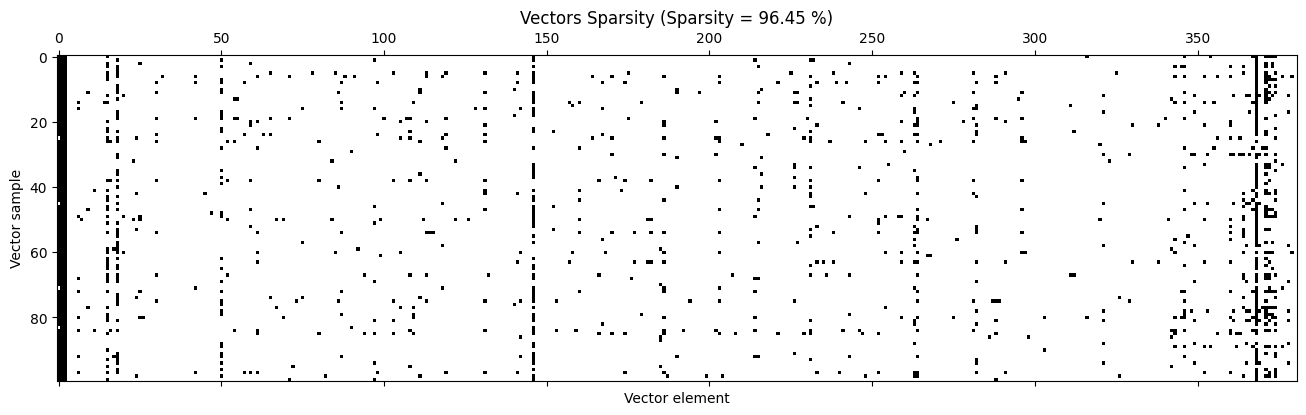

In [ ]:
#analisando os primeiros 100 primeiros vetores e verificando as esparcidade dos dados 
# lembrando quanto mais proximo de  100 maior esparcidade , mais proximo de 0  ( não tem esparsidade )
def plot_vector_sparsity(vectors:pd.DataFrame, figsize=(16, 10), n_samples=100):
    filled_entries = vectors.astype(bool).sum().sum()
    overall_sparsity = 1-filled_entries/(vectors.shape[0]*vectors.shape[1])

    fig, ax = plt.subplots(figsize=figsize)
    ax.spy(vectors.sample(n_samples))
    ax.set_title('Vectors Sparsity (Sparsity = {:.02f} %)'.format(100*overall_sparsity))
    ax.set_xlabel('Vector element')
    ax.set_ylabel('Vector sample')
    return fig, ax

plot_vector_sparsity(df_vectors, n_samples=100)

## Análise de variância explicada

Para reduzir a dimensionalidade dos vetores podemos adicionar a classe
 [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) em nosso pipeline de transformações. 

No entanto, um dos parâmetros fundamentais para a PCA é o **número de componentes principais** 
que será utiliado após as transformações. Este número de componente define o **tamanho do vetor** a ser utilizado para o cálculo de similaridades.

In [44]:
# Treino com o PCA 

from sklearn.decomposition import PCA
n_components = df_train.shape[1]

pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('decomposition', PCA(n_components=381))])

Para decidir o número de componentes principais a ser utilizado na PCA podemos fazer uma **análise de variância explicada**: quanto mais componentes principais são utilizados na PCA maior a explicabilidade da variância.

Em geral, podemos considerar um número de componentes principais suficientes para explicar **90%** da variância dos dados de entrada.

(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Cumulative Explained Variance (381 components)'}, xlabel='Principal Components'>)

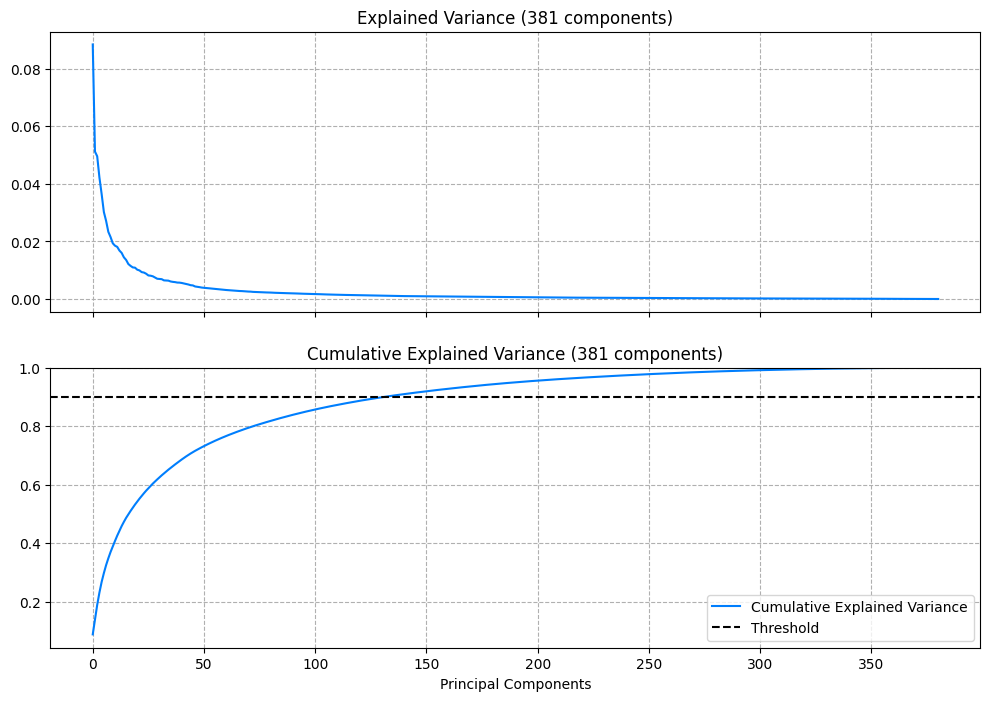

In [23]:
def plot_explained_variance(explained_variance, figsize=(16,8), threshold=0.9, cumulative=True):
    label = 'Explained Variance'
    n_componenents = len(explained_variance)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    ax = axes[0]
    ax.plot(explained_variance, label=label)

    ax.set_title(f'{label} ({n_components} components)')

    ax = axes[1]
    label = f'Cumulative {label}'
    ax.plot(np.cumsum(explained_variance), label=label)
    ax.axhline(threshold, c='black', linestyle='--', label='Threshold')
    ax.set_title(f'{label} ({n_components} components)')
    ax.set_xlabel('Principal Components')
    ax.set_ylim(top=1.0)
    ax.legend()
    [ax_i.grid(True, linestyle='--') for ax_i in axes]
    return fig, ax

explained_variance_ratio = pipeline_pca.named_steps['decomposition'].explained_variance_ratio_
plot_explained_variance(explained_variance_ratio, cumulative = False, figsize=(12,8))

## Redução de dimensionalidade

Através da análise gráfica podemos escolher um número de componentes final a ser utilizado para a PCA.

In [24]:
n_components = 150
pipeline_pca = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('decomposition', PCA(n_components=n_components))
])

pipeline_pca.fit(df_train)

df_vectors_pca = generate_vector_representation(pipeline_pca, df_train, keep_columns=False)
df_vectors_pca.tail()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
id,,,,,,,,,,,,,,,,,,,,,
9970,-0.678987,-0.427745,0.392028,-0.143320,-0.671988,0.127962,0.131818,0.266490,-0.766825,-0.197784,...,-0.010986,0.025865,-0.007595,0.017552,-0.001619,0.022236,-0.003476,-0.006177,0.015422,0.010615
99700,0.045390,-0.225525,-0.615700,0.374983,0.730148,0.123234,1.159890,0.966161,0.532615,0.382058,...,-0.075164,-0.016022,-0.051224,-0.045504,-0.044485,0.036828,-0.016491,-0.014894,-0.026669,-0.002705
9980,-0.854433,-0.377767,-0.552167,0.089070,0.203783,-0.073796,0.816582,-0.242471,0.068920,-0.108289,...,-0.077429,0.046871,-0.077415,-0.086629,-0.033566,0.049020,-0.012673,-0.010102,-0.024564,0.031835
99900,1.669908,-0.189964,1.205550,0.582277,0.685167,1.183369,0.024355,-1.069412,-0.310266,0.859328,...,0.094939,0.055048,-0.038759,-0.089595,-0.024928,0.227336,0.017404,-0.007354,0.120529,-0.081672
99910,0.239036,-0.474338,0.485375,0.000911,1.173145,0.509232,0.430435,-1.146643,0.524939,0.008349,...,-0.079844,0.059950,0.012345,-0.117957,-0.033073,0.016331,0.094977,-0.133867,-0.095880,-0.046708


In [25]:
print ('Dimensão dos vetores (pré-PCA):', df_vectors.shape[1])
print ('Dimensão dos embeddings (pós-PCA):', df_vectors_pca.shape[1])

Dimensão dos vetores (pré-PCA): 381
Dimensão dos embeddings (pós-PCA): 150


Após a redução de dimensionalidade, podemos rever a esparsidade dos vetores a serem utilizados para o cálculo de similaridade

(<Figure size 1600x1000 with 1 Axes>,
 <Axes: title={'center': 'Vectors Sparsity (Sparsity = 0.00 %)'}, xlabel='Vector element', ylabel='Vector sample'>)

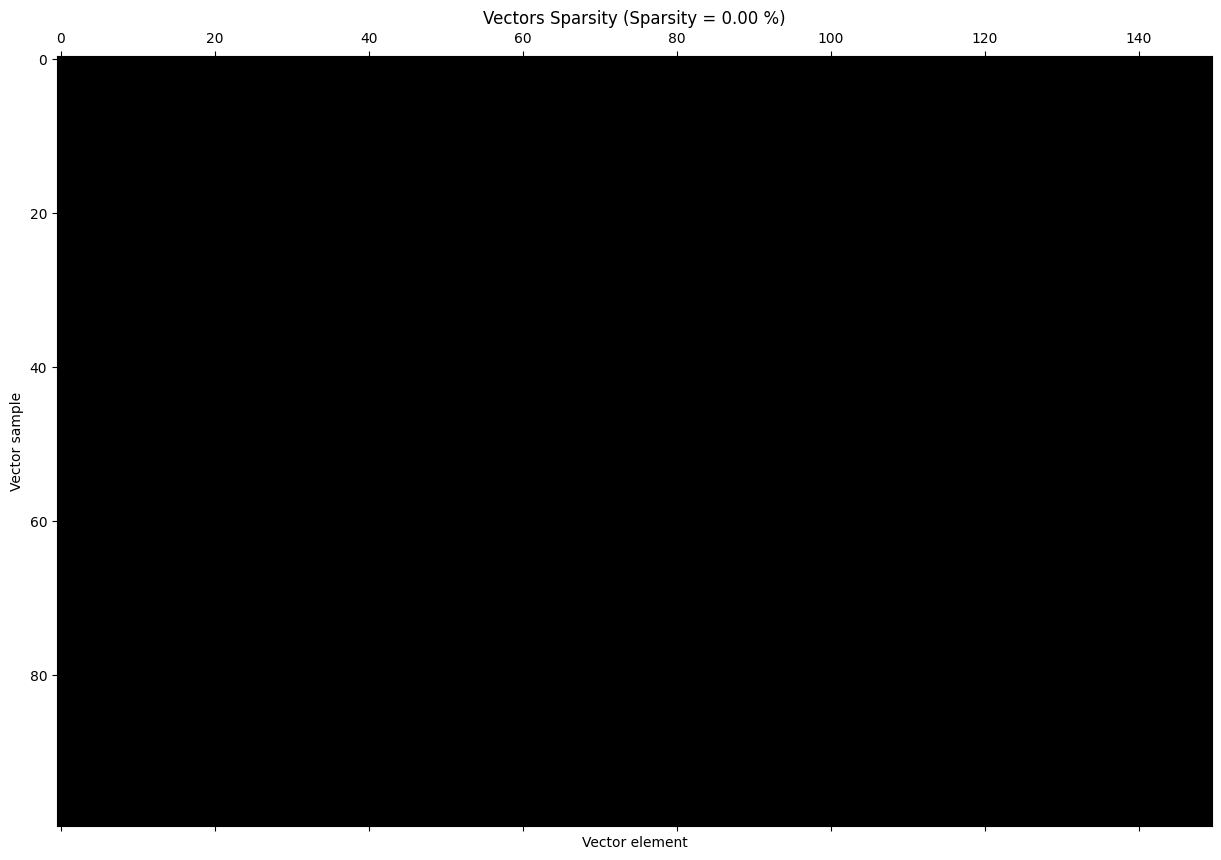

In [26]:
plot_vector_sparsity(df_vectors_pca, n_samples=100)

## Calculando a matriz de similaridades item-item com embeddings

Quando um vetor tem a sua informação compactada chamamos o vetor resultante de **embedding**. Esses embeddings gerados pela PCA podem ser utilizados para o cálculo de similaridade entre os itens de forma análoga ao cálculo com os vetores em representação maximamente esparsa.

In [27]:
%%time
df_item_similarity_matrix_pca = calculate_similarity_matrix(df_vectors_pca)
df_item_similarity_matrix_pca.shape

CPU times: total: 5.42 s
Wall time: 3.05 s


(19442, 19442)

In [45]:
%%time
df_item_similarity_matrix_pca = calculate_similarity_matrix(df_vectors_pca)
df_item_similarity_matrix_pca


CPU times: total: 6.09 s
Wall time: 3.45 s


id,10,1002,100400,10090,100980,10100,10110,10120,10130,10140,...,99300,9940,99400,99410,9960,9970,99700,9980,99900,99910
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.200474,0.197718,0.423687,0.157750,0.126711,0.112479,0.085310,0.515393,0.063086,...,0.049275,-0.131372,-0.037885,0.012385,-0.017551,0.087885,-0.031831,-0.018736,-0.034532,0.104236
1002,0.200474,1.000000,0.232224,0.105864,0.140813,0.040098,0.026157,0.024667,0.271711,0.231331,...,-0.002044,-0.241397,0.032579,0.177630,0.117500,0.081194,0.011611,0.107376,-0.028540,0.124197
100400,0.197718,0.232224,1.000000,-0.032995,0.827531,0.212241,0.178437,0.282015,0.082763,0.512944,...,-0.020326,-0.287115,-0.012607,0.130676,0.404449,0.310096,-0.022703,0.316375,-0.305847,-0.066469
10090,0.423687,0.105864,-0.032995,1.000000,-0.059026,0.107330,0.089828,0.002769,0.484708,-0.018600,...,0.183737,-0.024759,-0.116565,-0.062410,0.043299,0.013913,-0.062814,-0.062934,0.249681,0.202469
100980,0.157750,0.140813,0.827531,-0.059026,1.000000,0.152103,0.126442,0.180735,0.033309,0.409358,...,-0.051274,-0.133723,-0.095798,0.029949,0.289805,0.203274,-0.065278,0.222733,-0.312303,-0.101077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,0.087885,0.081194,0.310096,0.013913,0.203274,0.086062,0.228925,0.699014,0.141948,0.294588,...,0.033647,-0.031674,0.436502,0.595110,0.533275,1.000000,-0.127481,0.175964,-0.119302,-0.164034
99700,-0.031831,0.011611,-0.022703,-0.062814,-0.065278,-0.072600,-0.073302,0.026865,0.083777,-0.001636,...,-0.157695,-0.021277,-0.144282,-0.067795,-0.111882,-0.127481,1.000000,0.359521,-0.074883,0.198010
9980,-0.018736,0.107376,0.316375,-0.062934,0.222733,0.106477,0.087406,0.392849,0.006364,0.306728,...,-0.066952,-0.287002,-0.101861,0.026999,0.224823,0.175964,0.359521,1.000000,-0.183378,0.171102


## Gerando recomendações com PCA

In [46]:
id = '12180'    # Grand Theft Auto 2
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.687030,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.590521,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.581776,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.553462,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.549347,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.530799,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
587650,0.520627,Half-Life 2: DownFall,"[Action, Free to Play, Violent, Gore, Mod, FPS..."
12100,0.519181,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


Testando diferentes itens de referência

In [29]:
id = '12180'  # Grand Theft Auto 2 
# id = '10'     # Counter Striker
# id = '221040' # Resident Evil 6
# id = '252950' # Rocket League
# id = '338300' # Disney'Chicken
# id = '226580' # F1
# id = '260210' # Assassin's Creed
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
12180,1.000000,Grand Theft Auto 2,"[Action, Classic, Open World, Singleplayer, Sh..."
12170,0.687030,Grand Theft Auto,"[Action, Classic, Open World, Singleplayer, 2D..."
38430,0.590521,Kingpin — Life of Crime,"[Action, FPS, Singleplayer, Crime, Classic, Go..."
2610,0.581776,GUN™,"[Western, Action, Open World, Third-Person Sho..."
40990,0.553462,Mafia,"[Action, Adventure, Violent, Story Rich, Class..."
299050,0.549347,Blood II: The Chosen + Expansion,"[Action, Adventure, FPS, Gore, Classic, Horror..."
6880,0.530799,Just Cause,"[Action, Open World, Shooter, Third Person, Si..."
587650,0.520627,Half-Life 2: DownFall,"[Action, Free to Play, Violent, Gore, Mod, FPS..."
12100,0.519181,Grand Theft Auto III,"[Open World, Action, Classic, Third Person, Si..."


In [49]:
id = df.sample().index[0]
df_recommended_items_pca = recommend_similar_items(df_item_similarity_matrix_pca, id)
display_recommendations(df_recommended_items_pca, df[['title', 'tags']])

,score,title,tags
id,,,
306510,1.000000,CRYENGINE - Sample Assets,None
325670,1.000000,CRYENGINE - Wwise Project DLC,None
338440,0.737227,BOMB Dedicated Server,None
353420,0.737112,Syber Steam Machine,"[Steam Machine, Hardware]"
382990,0.737029,BrainBread 2 Mod Tools,None
451330,0.737029,IS Defense Editor,None
531340,0.737028,Steam Controller Skin - CSGO Blue/Orange,None
531360,0.737028,Steam Controller Skin - CSGO Grey Camo,None
531430,0.737028,Steam Link Skin - CSGO Blue/Orange,None
